<a href="https://colab.research.google.com/github/serveer/Sarcasm_Detection/blob/main/545_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import string
import copy
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
!pip install eli5

     |████████████████████████████████| 106 kB 8.0 MB/s 


In [ ]:
import nltk
nltk.download('punkt')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Exploration**

## Explore Dataset

In [ ]:
from google.colab import drive
sar_df = pd.read_csv('/content/drive/MyDrive/archive/train-balanced-sarcasm.csv')

In [ ]:
sar_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [ ]:
sar_df[sar_df['score']>8000]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
143497,1,That's exactly what a country who made up a ho...,ThePandagator,worldnews,9070,-1,-1,2016-11,2016-11-16 17:44:28,China Tells Trump That Climate Change Is No Ho...


In [ ]:
sar_df[sar_df['author'] == 'ThePandagator']

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
143497,1,That's exactly what a country who made up a ho...,ThePandagator,worldnews,9070,-1,-1,2016-11,2016-11-16 17:44:28,China Tells Trump That Climate Change Is No Ho...
166406,0,Borderlands is going to be a real thing I guess.,ThePandagator,politics,18,-1,-1,2016-12,2016-12-18 16:12:51,"The new and improved CSA, Corporate States of ..."


Initially,we proposed our guess that the score is for author's reddit Karma credits. However, for the same author ThePandagator, his score changes dramatically between 2016-11 and 2016-12. 

In [ ]:
sar_df[sar_df['author'] == 'Creepeth']

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
11544,0,I guess Moncrief really is hurt.,Creepeth,Patriots,1,1,0,2016-09,2016-09-21 13:15:38,Colts sign Devin Street off of the Patriots pr...
11920,1,I can't believe Cleveland hasn't won a game wi...,Creepeth,nfl,17,-1,-1,2016-11,2016-11-01 17:19:45,"Most cap space: CLE $50.2M, SF $42.0M, JAX $40..."
11921,1,No Sausage Party?,Creepeth,movies,1,-1,-1,2016-11,2016-11-26 23:46:04,I hope it gets nominated for Best Animated Fil...
34066,1,I can't believe we traded away Chandler to fea...,Creepeth,nfl,3,-1,-1,2016-10,2016-10-18 17:05:01,"Top 5 in QB Hurries- Donald, Ingram, Hughes, S..."
44220,1,"Wow, so preseason games do matter",Creepeth,nfl,5,5,0,2016-09,2016-09-19 15:47:31,All four teams that went undefeated in the pre...
58185,0,you're really embracing this self-loathing thi...,Creepeth,nfl,5,-1,-1,2016-10,2016-10-18 02:01:51,"check the flair, man -- never claimed i was im..."
173892,0,"This video will be gold, jerry, gold.",Creepeth,nfl,3,-1,-1,2016-10,2016-10-05 22:28:06,NFL will clarify illegal 'sexually suggestive'...


To prove our guess, we explore more with Creepeth and find the same issue. The same author has different score. Therefore, we conclude that the score should be for each comments rather than author itself.

In [ ]:
sar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


When we read this whole dataset, we find some columns a little bit confusing. We hope to know the exact meaning of label,score,ups and downs.
By analyzing the sentiment, we can know 1 means sarcasm and 0 means not.

In [ ]:
sar_df.count(axis = 'rows')

label             1010826
comment           1010773
author            1010826
subreddit         1010826
score             1010826
ups               1010826
downs             1010826
date              1010826
created_utc       1010826
parent_comment    1010826
dtype: int64

From the output, we can see all columns' data size are the same 1010826 except for comment column. Now we hope to explore comment column.

In [ ]:
sar_df[pd.isna(sar_df['comment']) == True].head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
56269,1,NaN,SodokuIRL,leagueoflegends,1,1,0,2016-09,2016-09-28 08:23:04,"LPL shitshow, EU LCS shitshow. What isn't a sh..."
68590,1,NaN,TossTheDog,westchesterpa,1,-1,-1,2016-10,2016-10-11 20:25:52,Car fires smell delicious to you? You should p...
135348,0,NaN,So12rovv,R6STeams,1,-1,-1,2016-12,2016-12-22 17:24:05,Will do. EU or NA?
199910,0,NaN,Khvostov_7g-02,tf2,1,1,0,2016-05,2016-05-16 05:46:43,"woah, thanks."
258718,1,NaN,PeaceLovePositivity,vaporents,5,5,0,2016-06,2016-06-22 20:37:11,"No, doing drugs while forming a fetus (your ki..."


These rows are a little bit annoying because their comment contains null value.We can drop these rows since we can ignore 53 rows compared to 1.3 million rows.

In [ ]:
#dropping na columns
sar_df=sar_df.dropna(subset=['comment'])

## Time Analysis

In [ ]:
sar_df1 = sar_df.groupby(by = ['date','label'],dropna=True).agg({'comment':'count'})

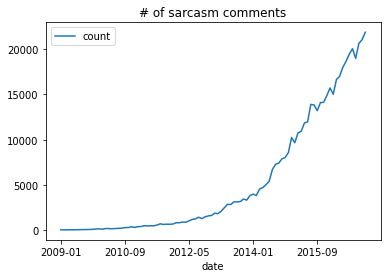

In [ ]:
sar_date_df = sar_df1.reset_index().rename(columns = {'comment':'count'})
sar_date = sar_date_df[sar_date_df['label'] == 1]
sar_date.plot(x='date',y='count')
plt.title('# of sarcasm comments')
plt.show()

Initially,we analyzed the change of sarcasm comments along the time and found the early data volume is too small. Then we proposed a guess that it's because at that time, many comments which are supposed to be sarcasm but failed to be truly classfied.

In [ ]:
sar_df1=sar_df1.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
sar_df1 = sar_df1.reset_index()
sar_df1 = sar_df1.rename(columns={'comment':'percentage'})
sar_df1 = sar_df1[sar_df1['label'] == 1]

<Figure size 7200x7200 with 0 Axes>

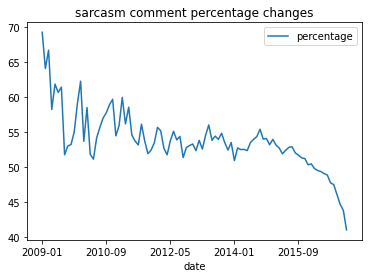

In [ ]:
plt.figure(figsize=(100,100))
sar_df1.plot(x='date',y='percentage')
plt.title('sarcasm comment percentage changes')
plt.show()

 However,after we calculate the percentage of sarcasm comments along the time, we find it important to keep. And acutally, the percentage of sarcasm comments decreases as time passed. Therefore we decide to keep data from earlier. 


# **Data Visualization**

## Score

Firstly,we hope to visualize the score effects on both sarcasm and nonsarcasm comments to find whether there is any difference. However, when we try to directly use the score. The data is so dense. So we look for log transformation.

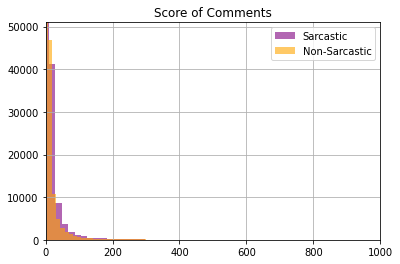

In [ ]:
sar_df[sar_df['label']==1]['score'].hist(alpha=0.6,bins=500,label='Sarcastic', color = 'purple')
sar_df[sar_df['label']==0]['score'].hist(alpha=0.6,bins=500,label='Non-Sarcastic', color = 'orange')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,51000)
plt.title('Score of Comments')
plt.show()

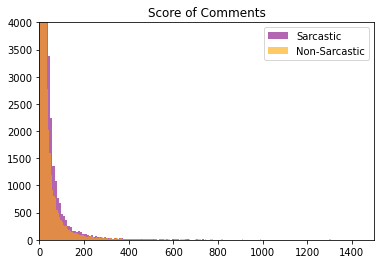

In [ ]:
plt.hist(sar_df[sar_df['label']==1]['score'],bins=1000,alpha=0.6,label='Sarcastic', color = 'purple')
plt.hist(sar_df[sar_df['label']==0]['score'],bins=1000,alpha=0.6,label='Non-Sarcastic', color = 'orange')
plt.legend()
plt.xlim(0,1500)
plt.ylim(0,4000)
plt.title('Score of Comments')
plt.show()

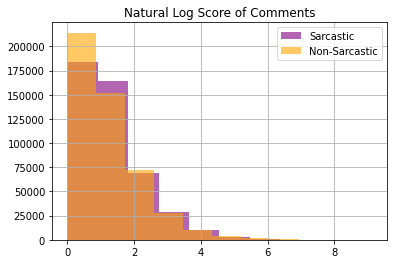

In [ ]:
sar_df['log_score'] = sar_df['score'].apply(lambda s: np.log1p(s))#log1p(s):log(1+x)
sar_df = sar_df.replace([-np.inf,np.inf],np.nan).dropna()#we hope to drop if there is anylog1p(s) goes to infinite
sar_df[sar_df['label']==1]['log_score'].hist(alpha=0.6,label='Sarcastic', color = 'purple')
sar_df[sar_df['label']==0]['log_score'].hist(alpha=0.6,label='Non-Sarcastic', color = 'orange')
plt.legend()
plt.title('Natural Log Score of Comments')
plt.show()

Since the dataset is balanced.It's not necessary to calculate the percentage to compare. According to the graph. We can easily find that there is a higher chance for non-sarcastic comments appear in the low score area.

In [ ]:
sar_length = sar_df.loc[sar_df['label'] == 1, 'comment'].str.len()
nonsar_length = sar_df.loc[sar_df['label'] == 0, 'comment'].str.len()
sar_length_df = pd.DataFrame(sar_length).rename(columns={'comment':'length'})
nonsar_length_df = pd.DataFrame(nonsar_length).rename(columns={'comment':'length'})

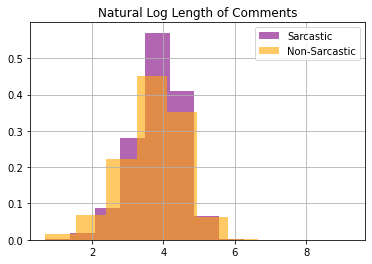

In [ ]:
sar_length_df['log_length'] = sar_length_df['length'].apply(lambda s: np.log1p(s))#log1p(s):log(1+x)
sar_length_df = sar_length_df.replace([-np.inf,np.inf],np.nan).dropna()#we hope to drop if there is anylog1p(s) goes to infinite
sar_length_df['log_length'].hist(density = True, alpha=0.6,label='Sarcastic', color = 'purple')
nonsar_length_df['log_length'] = nonsar_length_df['length'].apply(lambda s: np.log1p(s))#log1p(s):log(1+x)
nonsar_length_df = nonsar_length_df.replace([-np.inf,np.inf],np.nan).dropna()#we hope to drop if there is anylog1p(s) goes to infinite
nonsar_length_df['log_length'].hist(density = True,alpha=0.6,label='Non-Sarcastic', color = 'orange')
plt.legend()
plt.title('Natural Log Length of Comments')
plt.show()

Similarly,we hope to explore the length of comments using log transformation

## Subreddit

In [ ]:
sar_df2 = sar_df.groupby(by = ['subreddit','label'],dropna=True).agg({'comment':'count'}).reset_index().rename(columns = {'comment':"count"})

In [ ]:
sar_subreddit_top100 = sar_df2[sar_df2['label']==1].sort_values(by='count',ascending=False).head(100)
nonsar_subreddit_top100 = sar_df2[sar_df2['label'] == 0].sort_values(by='count',ascending = False).head(100)

In [ ]:
distinct_sar_subreddit = []
for sub in sar_subreddit_top100['subreddit'].tolist():
  if sub not in nonsar_subreddit_top100['subreddit'].tolist():
    distinct_sar_subreddit.append(sub)
distinct_sar_subreddit_df = sar_subreddit_top100[sar_subreddit_top100['subreddit'].isin(distinct_sar_subreddit)]


<Figure size 7.2e+07x7.2e+07 with 0 Axes>

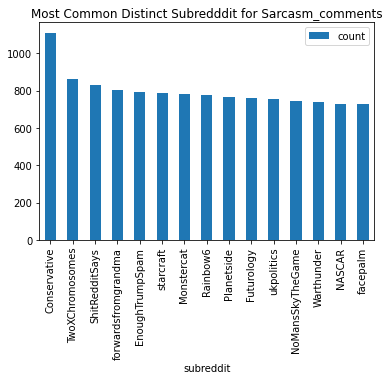

In [ ]:
plt.figure(figsize = (1000000, 1000000))
distinct_sar_subreddit_df.plot(x = 'subreddit',y='count',kind='bar')
plt.title('Most Common Distinct Subredddit for Sarcasm_comments')
plt.show()

It's quite interesting that Conservative  and TrumpSpam ranks so high in distinct subreddit for sarcasm comments.They do not show up in top100 nonsarcasm comments. Perhaps users in Reddit tend to have a political preferrence to be against to Conservative Party. Furthermore, we can find that the subreddit tends to be more complex and the length tends to be longer for sarcasm comments.

In [ ]:
distinct_nonsar_subreddit = []
for sub in nonsar_subreddit_top100['subreddit'].tolist():
  if sub not in sar_subreddit_top100['subreddit'].tolist():
    distinct_nonsar_subreddit.append(sub)
distinct_nonsar_subreddit_df = nonsar_subreddit_top100[nonsar_subreddit_top100['subreddit'].isin(distinct_nonsar_subreddit)]

<Figure size 7200x7200 with 0 Axes>

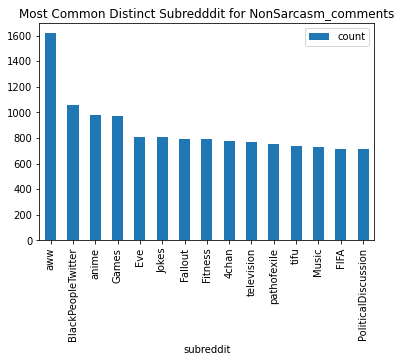

In [ ]:
plt.figure(figsize = (100, 100))
distinct_nonsar_subreddit_df.plot(x = 'subreddit',y='count',kind='bar')
plt.title('Most Common Distinct Subredddit for NonSarcasm_comments')
plt.show()

Compared to distinct_sar_subreddit, we can find that the distinct_nonsar_subreddit tends to be shorter.And the subreddits here tend to be more ordinary such as games,television or music.

## Comment

In [ ]:
sar_com = sar_df[sar_df['label']==1]['comment'].apply(str).tolist()
nonsar_com= sar_df[sar_df['label']==0]['comment'].apply(str).tolist()
# TODO: Create tokenized_content(content)
def tokenized_content(content):
  content = nltk.word_tokenize(content)
  tokenized_word = [word.lower() for word in content if not word.lower() in stopwords]
  alpha_words = [word for word in tokenized_word if word.isalpha()]
  return alpha_words
# TODO: Tokenize and flatten
sar = []
for sub in sar_com:
    sar.append(tokenized_content(sub))
nonsar = []
for sub in nonsar_com:
  nonsar.append(tokenized_content(sub))
sar_tokens = []
for sub in sar:
  for ele in sub:
    sar_tokens.append(ele)
nonsar_tokens = []
for sub in nonsar:
  for ele in sub:
    nonsar_tokens.append(ele)


In [ ]:
# TODO: Find 20 most common words amongst the content of your highest and lowest questions
sar_most_common = Counter(sar_tokens).most_common(20)
nonsar_most_common = Counter(nonsar_tokens).most_common(20)

In [ ]:
#find the most common distinct words for sarcasm comments
sar = copy.deepcopy(Counter(sar_tokens))
nonsar = copy.deepcopy(Counter(nonsar_tokens))
sar.subtract(nonsar)
distinct_sar = sar
distinct_sar_most_common = sar.most_common(20)
#find the most common distinct words for non_sarcasm comments
sar = copy.deepcopy(Counter(sar_tokens))
nonsar.subtract(sar)
distinct_nonsar = nonsar
distinct_nonsar_most_common = nonsar.most_common(20)
#find the most common overlap words
sar = copy.deepcopy(Counter(sar_tokens))
nonsar = copy.deepcopy(Counter(nonsar_tokens))
overlap = sar&nonsar

In [ ]:
overlap_top100 = overlap.most_common(100)
more_common_overlapwords = []
for each in overlap_top100:
    more_common_overlapwords.append(each[0])
sar_most_common_word = []
for each in distinct_sar_most_common:
    sar_most_common_word.append(each[0])
nonsar_most_common_word = []
for each in distinct_nonsar_most_common:
    nonsar_most_common_word.append(each[0])

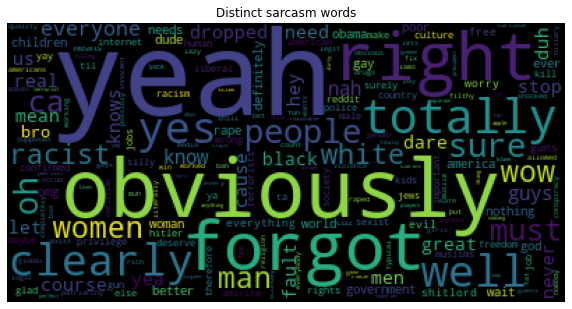

In [ ]:
wordcloud1 = WordCloud().generate_from_frequencies(distinct_sar)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud1) 
plt.axis("off")  
plt.title("Distinct sarcasm words")
plt.show() 


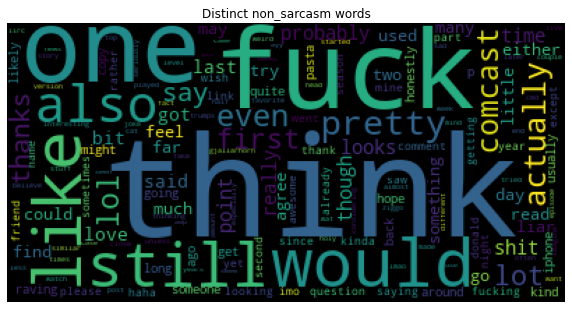

In [ ]:
wordcloud1 = WordCloud().generate_from_frequencies(distinct_nonsar)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud1) 
plt.axis("off")  
plt.title("Distinct non_sarcasm words")
plt.show() 

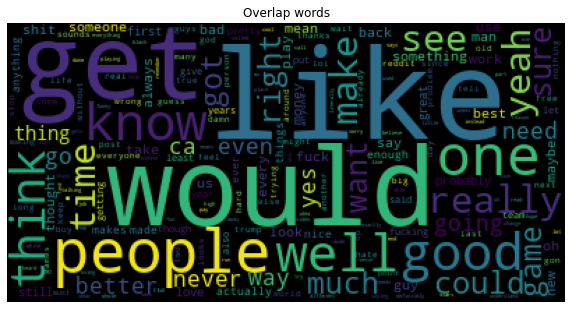

In [ ]:
wordcloud1 = WordCloud().generate_from_frequencies(overlap)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud1) 
plt.axis("off")  
plt.title("Overlap words")
plt.show() 

#**DATA PREPROCESSING**

In [ ]:
def count_num_common_slang(text):
    common_slang = ["kms", "smh", "smdh", "smfh", "rofl", "roflmao", "sic", 
                    "lol", "yolo", "ikr ", "dfkm", "lmao", "ofc", "surprise surprise",
                    "dope","lit","tbh","bruh","jk","jkjk"]
    count = 0
    for word in text.split():
      if word.lower() in common_slang:
        count+=1
    return count

def count_num_overlap(text):
    count = 0
    for word in text.split():
      if word.lower() in more_common_overlapwords:
        count+=1
    return count

def count_num_exclamation_marks(text):
    return text.count("!")

def count_num_sarc_dist(text):
    count = 0
    for word in text.split():
      if word.lower() in sar_most_common_word:
        count+=1
    return count

def count_num_nonsarc_dist(text):
    count = 0
    for word in text.split():
      if word.lower() in nonsar_most_common_word:
        count+=1
    return count

In [ ]:
sar_df['overlap_count']=sar_df['comment'].apply(lambda x:count_num_overlap(x))
sar_df['exclamation_count']=sar_df['comment'].apply(lambda x:count_num_exclamation_marks(x))
sar_df['slang_count']=sar_df['comment'].apply(lambda x:count_num_common_slang(x))
sar_df['dist_sarc_count']=sar_df['comment'].apply(lambda x:count_num_sarc_dist(x))
sar_df['dist_nonsarc_count']=sar_df['comment'].apply(lambda x:count_num_nonsarc_dist(x))
sar_df['len']=sar_df['comment'].apply(lambda x:len(x))
sar_df['log_length']=sar_df['len'].apply(lambda x: np.log1p(x))

Preprocess the context of comments.

In [ ]:
# convert all words in headline into lower case 
sar_df['comment'] = sar_df['comment'].apply(lambda x:x.lower())  
# remove all punctuations in headline
sar_df['comment'] = sar_df['comment'].apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))

We tried stemming the words but that got us lower accuracy

In [ ]:
#from nltk.stem import PorterStemmer
#ps = PorterStemmer()
#sar_df['comment'] = sar_df.comment.apply(lambda x: ' '.join(ps.stem(word) for word in x.split()))

In [ ]:
tf_idf=TfidfVectorizer()
multi=MultinomialNB()
param_grid = {
'tf_idf__max_features':[3000,5000,None],
'tf_idf__ngram_range': [(1,1),(1,2)],
'tf_idf__min_df': [0,3,5],
'tf_idf__max_df':[0.8,0.95,1.0]}
pipe = Pipeline([('tf_idf',tf_idf),('multi',multi)])
gs = GridSearchCV(pipe, param_grid).fit(sar_df['comment'],sar_df['label'])

In [ ]:
print(gs.best_params_)

{'tf_idf__max_df': 0.95, 'tf_idf__max_features': None, 'tf_idf__min_df': 0, 'tf_idf__ngram_range': (1, 2)}


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(sar_df['comment'],sar_df['label'],test_size=0.2)

In [ ]:
best_tf_idf=TfidfVectorizer(stop_words=stopwords,max_df=0.95,max_features=50000,min_df=0,ngram_range=(1,2))
X_train=best_tf_idf.fit_transform(X_train)
X_test=best_tf_idf.transform(X_test)

In [ ]:
X_train.shape

(1010773, 50000)

# **Modeling**

## Baseline Model

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(n_jobs=5)
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

**Precision, Recall, F1 Score, and ROC**

In [ ]:
y_test_pred=lr.predict(X_test)
print('Train Accuracy: %.4f' %lr.score(X_train,y_train))
print('Test Accuracy: %.4f' %lr.score(X_test,y_test))
print('Precision: %.4f' %precision_score(y_true=y_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y_test,lr.predict_proba(X_test)[:, 1]))

Train Accuracy: 0.7184
Test Accuracy: 0.6891
Precision: 0.6984
Recall: 0.6342
F1: 0.6648
Area under ROC Curve: 0.7534


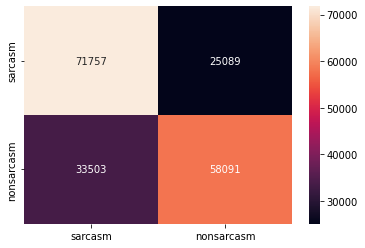

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_test_pred), annot=True, fmt="d",
            xticklabels=['sarcasm','nonsarcasm'],yticklabels=['sarcasm','nonsarcasm'])

Model preformance is not that good

### RandomForest

In [ ]:
rf_param_grid = {'n_estimators':[32,64],'max_depth': [30,40]}
rf = RandomForestClassifier(criterion='entropy')
rf_cv = GridSearchCV(rf, rf_param_grid).fit(X_train,y_train)

In [ ]:
rf_cv.best_estimator_

In [ ]:
best_rf=RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=64)
best_rf.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=64)

In [ ]:
y_pred=best_rf.predict(x_train)

In [ ]:
best_rf.score(x_train,y_train)

0.63603994170798

In [ ]:
confusion_matrix(y_train, y_pred)

array([[400347, 105058],
       [262823, 242545]])

As you can see, Random Forest did worse, so we decided not to continue with Random Forest

## Feature Extraction

### Removal of Dirty Data

In [ ]:
sar_df.corr()

,label,score,ups,downs,overlap_count,exclamation_count,slang_count,dist_sarc_count,dist_nonsarc_count,len,log_score,log_length
label,1.000000,-0.004201,-0.000653,0.054298,0.001299,0.134812,-0.025008,0.167334,-0.014857,-0.002603,0.030703,0.074465
score,-0.004201,1.000000,0.848453,-0.012104,0.001319,-0.001754,-0.001014,-0.000306,0.000517,0.008211,0.419434,0.019181
ups,-0.000653,0.848453,1.000000,0.071087,0.001265,-0.002005,-0.001650,0.000650,0.000402,0.008449,0.393853,0.019438
downs,0.054298,-0.012104,0.071087,1.000000,-0.001785,0.012051,-0.013732,0.013229,-0.003684,0.007875,-0.029269,0.021617
overlap_count,0.001299,0.001319,0.001265,-0.001785,1.000000,-0.016022,0.001209,0.104072,0.724487,0.475585,0.004359,0.185669
exclamation_count,0.134812,-0.001754,-0.002005,0.012051,-0.016022,1.000000,-0.020186,-0.008903,-0.008117,-0.041846,0.007595,-0.044727
slang_count,-0.025008,-0.001014,-0.001650,-0.013732,0.001209,-0.020186,1.000000,-0.001080,0.018742,-0.003325,-0.007290,-0.019963
dist_sarc_count,0.167334,-0.000306,0.000650,0.013229,0.104072,-0.008903,-0.001080,1.000000,0.005833,0.150800,0.015637,0.200653
dist_nonsarc_count,-0.014857,0.000517,0.000402,-0.003684,0.724487,-0.008117,0.018742,0.005833,1.000000,0.384064,0.000003,0.062831
len,-0.002603,0.008211,0.008449,0.007875,0.475585,-0.041846,-0.003325,0.150800,0.384064,1.000000,0.034839,0.646504


Upon analyzing the augmented features we realize that non-sarcasm distinct has significantly lower correlation score

In [ ]:
sar_df[['label','comment','dist_nonsarc_count','len']].sort_values('dist_nonsarc_count',ascending=False).head(10)

,label,comment,dist_nonsarc_count,len
163043,0,fuck fuck fuck fuck fuck fuck fuck fuck fuck f...,2000,9999
104339,0,fuck fuck fuck fuck fuck fuck fuck fuck fuck f...,2000,9999
217579,0,comcast comcast comcast comcast comcast comcas...,1250,9999
382449,0,comcast comcast comcast comcast comcast comcas...,1243,9994
89444,0,fuck fuck fuck fuck fuck fuck fuck fuck fuck f...,1224,6119
164976,0,first family trump first family trump first fa...,200,3799
266603,0,comcast comcast comcast comcast comcast comcas...,188,1503
109391,0,first lady of the united states first lady of ...,125,3999
590640,0,well when you put it that way sounds fine but...,13,1026
64223,0,and the same time to be a lot of the same time...,12,360


By looking at the data, we realize there are a lot of dirty data repeating the same words that messes with distinct nonsarcasm word count

In [ ]:
sar_df=sar_df[sar_df['dist_nonsarc_count']<100]

In [ ]:
sar_com = sar_df[sar_df['label']==1]['comment'].apply(str).tolist()
nonsar_com= sar_df[sar_df['label']==0]['comment'].apply(str).tolist()
sar = []
for sub in sar_com:
    sar.append(tokenized_content(sub))
nonsar = []
for sub in nonsar_com:
  nonsar.append(tokenized_content(sub))
sar_tokens = []
for sub in sar:
  for ele in sub:
    sar_tokens.append(ele)
nonsar_tokens = []
for sub in nonsar:
  for ele in sub:
    nonsar_tokens.append(ele)
#find the most common distinct words for sarcasm comments
sar = copy.deepcopy(Counter(sar_tokens))
nonsar = copy.deepcopy(Counter(nonsar_tokens))
sar.subtract(nonsar)
distinct_sar = sar
distinct_sar_most_common = sar.most_common(20)
#find the most common distinct words for non_sarcasm comments
sar = copy.deepcopy(Counter(sar_tokens))
nonsar.subtract(sar)
distinct_nonsar = nonsar
distinct_nonsar_most_common = nonsar.most_common(20)
#find the most common overlap words
sar = copy.deepcopy(Counter(sar_tokens))
nonsar = copy.deepcopy(Counter(nonsar_tokens))
overlap = sar&nonsar
overlap_top100 = overlap.most_common(100)
more_common_overlapwords = []
for each in overlap_top100:
    more_common_overlapwords.append(each[0])
sar_most_common_word = []
for each in distinct_sar_most_common:
    sar_most_common_word.append(each[0])
nonsar_most_common_word = []
for each in distinct_nonsar_most_common:
    nonsar_most_common_word.append(each[0])

Overwriting the orignial features

In [ ]:
sar_df['dist_sarc_count']=sar_df['comment'].apply(lambda x:count_num_sarc_dist(x))
sar_df['dist_nonsarc_count']=sar_df['comment'].apply(lambda x:count_num_nonsarc_dist(x))
sar_df['len']=sar_df['comment'].apply(lambda x:len(x))

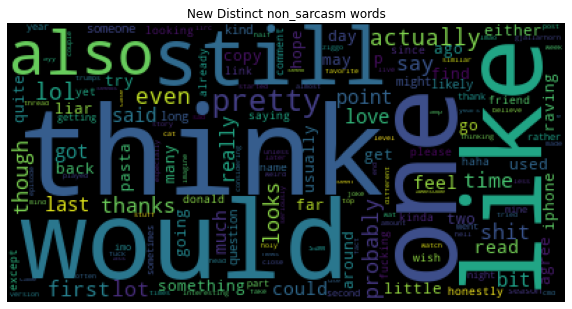

In [ ]:
wordcloud1 = WordCloud().generate_from_frequencies(distinct_nonsar)
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud1) 
plt.axis("off")  
plt.title("New Distinct non_sarcasm words")
plt.show() 

In [ ]:
sar_df.corr()

,label,score,ups,downs,slang_count,overlap_count,exclamation_count,dist_sarc_count,dist_nonsarc_count,len,log_score,log_length
label,1.000000,-0.004202,-0.000654,0.054288,-0.025008,0.003763,0.134810,0.195065,-0.092167,-0.000652,0.030702,0.078473
score,-0.004202,1.000000,0.848453,-0.012106,-0.001014,0.002503,-0.001754,-0.000619,0.003725,0.008877,0.419434,0.019146
ups,-0.000654,0.848453,1.000000,0.071086,-0.001650,0.002463,-0.002005,0.000774,0.002687,0.009101,0.393854,0.019291
downs,0.054288,-0.012106,0.071086,1.000000,-0.013733,0.002777,0.012047,0.022329,-0.001564,0.009102,-0.029274,0.020321
slang_count,-0.025008,-0.001014,-0.001650,-0.013733,1.000000,0.031475,-0.020186,-0.007433,0.112424,-0.002474,-0.007290,-0.017067
overlap_count,0.003763,0.002503,0.002463,0.002777,0.031475,1.000000,-0.027135,0.179748,0.305974,0.481026,0.008658,0.301538
exclamation_count,0.134810,-0.001754,-0.002005,0.012047,-0.020186,-0.027135,1.000000,-0.003278,-0.043340,-0.046770,0.007595,-0.048763
dist_sarc_count,0.195065,-0.000619,0.000774,0.022329,-0.007433,0.179748,-0.003278,1.000000,0.044945,0.188406,0.015510,0.238985
dist_nonsarc_count,-0.092167,0.003725,0.002687,-0.001564,0.112424,0.305974,-0.043340,0.044945,1.000000,0.269768,0.002752,0.307702
len,-0.000652,0.008877,0.009101,0.009102,-0.002474,0.481026,-0.046770,0.188406,0.269768,1.000000,0.037682,0.681986


Correlation for distinct words improved. Highest features are exclamation_count, dist_sarc_count, dist_nonsarc_count, and log_length.

## Enhanced Model

### Exclamation Mark

In [ ]:
enhanced_df=sar_df[['comment','exclamation_count','dist_sarc_count','dist_nonsarc_count','log_length']]
ct=ColumnTransformer([('tf_idf',best_tf_idf,'comment')],remainder='passthrough')
X3_train, X3_test, y3_train, y3_test=train_test_split(enhanced_df,sar_df['label'],test_size=0.2)
X3_train=ct.fit_transform(X3_train)
X3_test=ct.transform(X3_test)

In [ ]:
lr3=LogisticRegression(n_jobs=5)
lr3.fit(X3_train,y3_train)
y_test_pred=lr3.predict(X3_test)
print('Train Accuracy: %.4f' %lr3.score(X3_train,y3_train))
print('Test Accuracy: %.4f' %lr3.score(X3_test,y3_test))
print('Precision: %.4f' %precision_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y3_test,lr3.predict_proba(X3_test)[:, 1]))

Train Accuracy: 0.6961
Test Accuracy: 0.6898
Precision: 0.7116
Recall: 0.6354
F1: 0.6713
Area under ROC Curve: 0.7565


Overall metric did not imporve a lot, so we tried different variations of the features and found exclamation mark to be most useful.

In [ ]:
enhanced_df=sar_df[['comment','exclamation_count']]
ct=ColumnTransformer([('tf_idf',best_tf_idf,'comment')],remainder='passthrough')
X3_train, X3_test, y3_train, y3_test=train_test_split(enhanced_df,sar_df['label'],test_size=0.2)
X3_train=ct.fit_transform(X3_train)
X3_test=ct.transform(X3_test)

In [ ]:
lr3=LogisticRegression(n_jobs=5)
lr3.fit(X3_train,y3_train)

0.7242332700500032

In [ ]:
y_test_pred=lr3.predict(X3_test)
print('Train Accuracy: %.4f' %lr3.score(X3_train,y3_train))
print('Test Accuracy: %.4f' %lr3.score(X3_test,y3_test))
print('Precision: %.4f' %precision_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y3_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y3_test,lr3.predict_proba(X3_test)[:, 1]))

Train Accuracy: 0.7242
Test Accuracy: 0.6954
Precision: 0.7092
Recall: 0.6439
F1: 0.6750
Area under ROC Curve: 0.7618


### Subreddit

We knew subreddit(topic of discussion) could be useful for identifying sarcasm so we added it as a feature, model showed good improvement

In [ ]:
subreddit_enhanced_df=sar_df[['comment','subreddit','exclamation_count']]
subreddit_tf_idf=TfidfVectorizer(max_features=10000,stop_words=stopwords,max_df=0.95)
ct=ColumnTransformer([('tf_idf',best_tf_idf,'comment'),('subreddit_tf_idf',subreddit_tf_idf,'subreddit')],remainder='passthrough')
X4_train1, X4_test1, y4_train, y4_test=train_test_split(subreddit_enhanced_df,sar_df['label'],test_size=0.2,random_state=42)
X4_train=ct.fit_transform(X4_train1)
X4_test=ct.transform(X4_test1)

In [ ]:
lr4=LogisticRegression(n_jobs=5)
lr4.fit(X4_train,y4_train)

LogisticRegression(n_jobs=5)

In [ ]:
y_test_pred=lr4.predict(X4_test)
print('Train Accuracy: %.4f' %lr4.score(X4_train,y4_train))
print('Test Accuracy: %.4f' %lr4.score(X4_test,y4_test))
print('Precision: %.4f' %precision_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y4_test,lr4.predict_proba(X4_test)[:, 1]))

Train Accuracy: 0.7245
Test Accuracy: 0.7000
Precision: 0.7159
Recall: 0.6637
F1: 0.6888
Area under ROC Curve: 0.7682


## Model Analysis

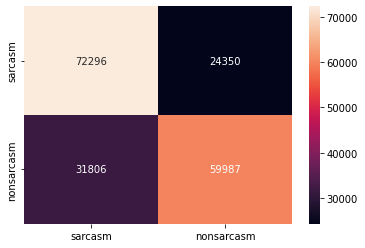

In [ ]:
sns.heatmap(confusion_matrix(y4_test,y_test_pred), annot=True, fmt="d",
            xticklabels=['sarcasm','nonsarcasm'],yticklabels=['sarcasm','nonsarcasm'])

In [ ]:
import eli5
eli5.show_weights(estimator=lr4,vec=ct,target_names=['nonsarcasm','sarcasm'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Weight?,Feature
+6.701,tf_idf__obviously
+6.240,tf_idf__gee
+5.636,tf_idf__totally
+5.320,tf_idf__forgot
+5.217,tf_idf__everyone knows
+5.203,tf_idf__shitlord
+5.133,tf_idf__clearly
+5.103,tf_idf__would never
+4.994,tf_idf__scrub
+4.908,tf_idf__good thing


From the words we know that model did pretty well, since we saw some of the words in the word cloud, next we will look at some misclassified examples

In [ ]:
error_list=np.where(y4_test!=y_test_pred)
error_list

(array([     5,      8,     10, ..., 188430, 188431, 188436]),)

In [ ]:
eli5.show_prediction(estimator=lr4,doc=X4_test[5],feature_names=ct.get_feature_names_out(subreddit_enhanced_df.columns),target_names=['nonsarcasm','sarcasm'])

In [ ]:
print(X4_test1.iloc[5])
print("Prediction: "+str(y_test_pred[5]))
print("Acutal: "+str(y4_test.iloc[5]))

comment              no flippy shit
subreddit             SquaredCircle
exclamation_count                 0
Name: 243722, dtype: object
Prediction: 0
Acutal: 1


In [ ]:
eli5.show_prediction(estimator=lr4,doc=X4_test[188431],feature_names=ct.get_feature_names_out(subreddit_enhanced_df.columns),target_names=['nonsarcasm','sarcasm'])

In [ ]:
print(X4_test1.iloc[188431,0])
print("Prediction: "+str(y_test_pred[188431]))
print("Acutal: "+str(y4_test.iloc[188431]))

i sure hope you didn't take those books from the library never know who might be watching
Prediction: 1
Acutal: 0


## Failed Attempts

###Model Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=42)
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=64,random_state=42)

In [ ]:
ada.fit(X4_train,y4_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=5,
                                                         random_state=42),
                   n_estimators=64, random_state=42)

In [ ]:
y_test_pred=ada.predict(X4_test)
print('Train Accuracy: %.4f' %ada.score(X4_train,y4_train))
print('Test Accuracy: %.4f' %ada.score(X4_test,y4_test))
print('Precision: %.4f' %precision_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y4_test,ada.predict_proba(X4_test)[:, 1]))

Train Accuracy: 0.6745
Test Accuracy: 0.6690
Precision: 0.7080
Recall: 0.5466
F1: 0.6169
Area under ROC Curve: 0.7228


In [ ]:
lr_ada = AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=5),learning_rate=0.1,random_state=42)
lr_ada.fit(X4_train,y4_train)

AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=5),
                   learning_rate=0.1, random_state=42)

In [ ]:
y_test_pred=lr_ada.predict(X4_test)
print('Train Accuracy: %.4f' %lr_ada.score(X4_train,y4_train))
print('Test Accuracy: %.4f' %lr_ada.score(X4_test,y4_test))
print('Precision: %.4f' %precision_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y4_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y4_test,lr_ada.predict_proba(X4_test)[:, 1]))

Train Accuracy: 0.5509
Test Accuracy: 0.5503
Precision: 0.6977
Recall: 0.1371
F1: 0.2291
Area under ROC Curve: 0.6533


Both logistic regression and decision tree boosting didn't give desired results, however it was better than random forest model previously

### Removal of Overlapping Words

In [ ]:
more_distinct_comment=sar_df.comment.apply(lambda x: ' '.join(word for word in x.split() if word not in more_common_overlapwords))
X1_train, X1_test, y1_train, y1_test=train_test_split(more_distinct_comment,sar_df['label'],test_size=0.2)
X1_train=best_tf_idf.fit_transform(X1_train)
X1_test=best_tf_idf.transform(X1_test)

In [ ]:
lr1=LogisticRegression(n_jobs=5)
lr1.fit(X1_train,y1_train)
lr1.score(X1_train,y1_train)

0.6999441461592856

In [ ]:
lr1.score(X1_test,y1_test)

0.6680782640536195

In [ ]:
overlap_top10 = overlap.most_common(10)
common_overlapwords = []
for each in overlap_top10:
    common_overlapwords.append(each[0])
distinct_comment=sar_df.comment.apply(lambda x: ' '.join(word for word in x.split() if word not in common_overlapwords))
X2_train, X2_test, y2_train, y2_test=train_test_split(distinct_comment,sar_df['label'],test_size=0.2)
X2_train=best_tf_idf.fit_transform(X2_train)
X2_test=best_tf_idf.transform(X2_test)

In [ ]:
lr2=LogisticRegression(n_jobs=5)
lr2.fit(X2_train,y2_train)

0.7146465752043442

In [ ]:
y_test_pred=lr2.predict(X2_test)
print('Train Accuracy: %.4f' %lr2.score(X2_train,y2_train))
print('Test Accuracy: %.4f' %lr2.score(X2_test,y2_test))
print('Precision: %.4f' %precision_score(y_true=y2_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Recall: %.4f' %recall_score(y_true=y2_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('F1: %.4f' %f1_score(y_true=y2_test, y_pred=y_test_pred, labels=[1,2],average='micro'))
print('Area under ROC Curve: %.4f' %roc_auc_score(y2_test,lr2.predict_proba(X2_test)[:, 1]))

Train Accuracy: 0.7146
Test Accuracy: 0.6867
Precision: 0.6999
Recall: 0.6263
F1: 0.6610
Area under ROC Curve: 0.7485


Getting rid of overlapping word doesn't improve accuracy, the more words we got rid of the worse the model accuracy